<a href="https://colab.research.google.com/github/PiotMik/OIS_curve_modeling/blob/main/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
from typing import Callable, Optional
sns.set()
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10, 8)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


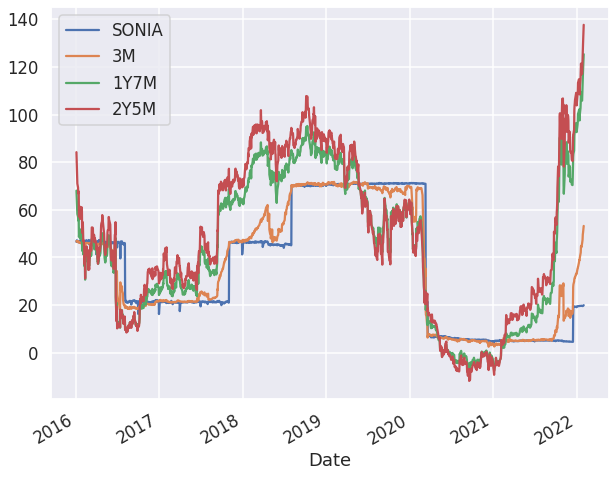

In [66]:
ois_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/OIS%20spot.csv'
sonia_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/SONIA.csv'
boe_url = '/content/drive/MyDrive/Shared Folder/OIS/BoE rate.csv'
def tenor_parser(month_number: int):
  """
  Refactor integer month number into string like: 23 -> '1Y3Q2M' 

  Parameters
  ----------
  month_number: int
    Integer representing the number of months
  
  Returns
  -------
  str
    Formatted string
  """
  years = np.floor(month_number/12)
  months = (month_number - 12*years)

  y_str = f"{int(years)}Y" * int(years > 0)
  m_str = f"{int(months)}M" * int(months > 0)
  
  return y_str + m_str

# OIS load
ois = pd.read_csv(ois_url,
                  index_col= ['Maturity'], parse_dates=True, dayfirst=True)
ois = ois.sort_index()*100.0
ois.columns = [tenor_parser(int(month)) for month in ois.columns]
ois.index.name = 'Date'

# SONIA load
sonia = pd.read_csv(sonia_url,
                    index_col=['Date'], parse_dates=True, dayfirst=True)
sonia = sonia.sort_index()* 100.0

# BOE load
boe = pd.read_csv(boe_url, 
                  sep=';', decimal=',',
                  index_col='Date', parse_dates=True, dayfirst=True).sort_index()*100.0

# Concatenate
rates = pd.concat([sonia, ois], axis = 1).dropna()

rates = boe.join(rates, how='right')
rates.loc[:,'BoE_rate'] = rates.loc[:, 'BoE_rate'].ffill()

rates.iloc[:, [1, 4, 20, 30]].plot()


In [67]:
tenor_subset = ['1M', '2M', '3M', '6M', '9M', '1Y']
df = rates[tenor_subset]

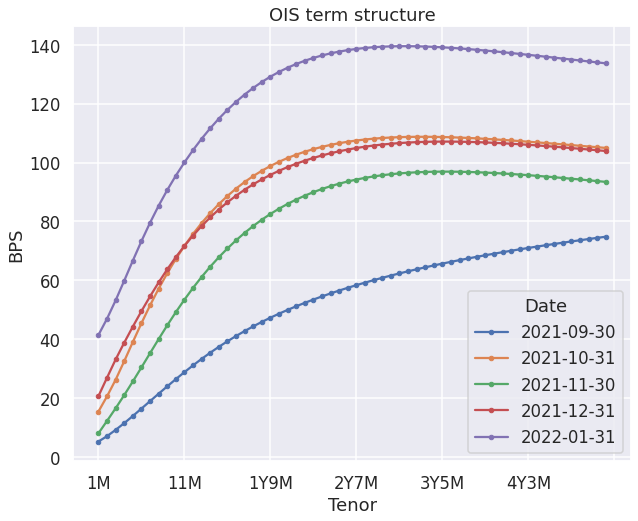

In [6]:
term_structure_df = rates.drop(['SONIA'], axis=1).tail(100).resample('M').last().T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')

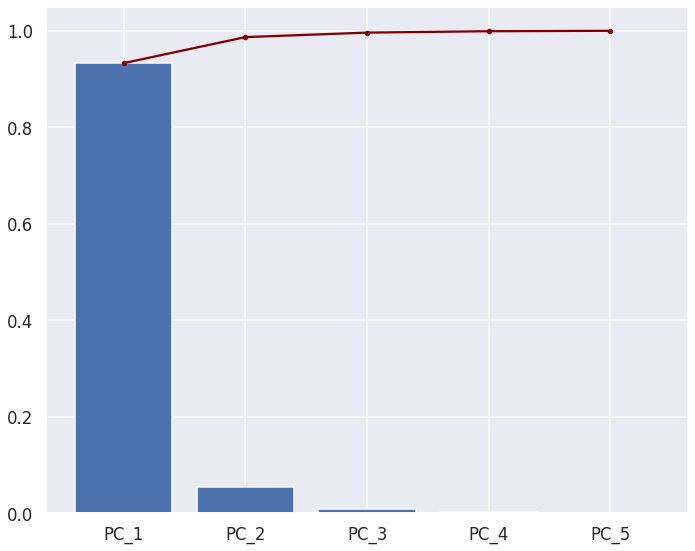

In [7]:
diffs = rates[ois.columns].diff().dropna()
pca = PCA()
pca.fit(diffs)

exp_var = pd.DataFrame(pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
exp_var['Cumulative explained variance'] = pca.explained_variance_ratio_.cumsum()

max_n = 5
plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
plt.tight_layout()

In [8]:
exp_var.head(10)

,Explained variance,Cumulative explained variance
PC_1,0.932507,0.932507
PC_2,0.053864,0.986371
PC_3,0.009336,0.995707
PC_4,0.002842,0.998550
PC_5,0.000874,0.999423
PC_6,0.000383,0.999806
PC_7,0.000131,0.999937
PC_8,0.000044,0.999981
PC_9,0.000014,0.999995
PC_10,0.000004,0.999999


,Cumulative explained variance
PC_1,0.907669
PC_2,0.986460
PC_3,0.997795


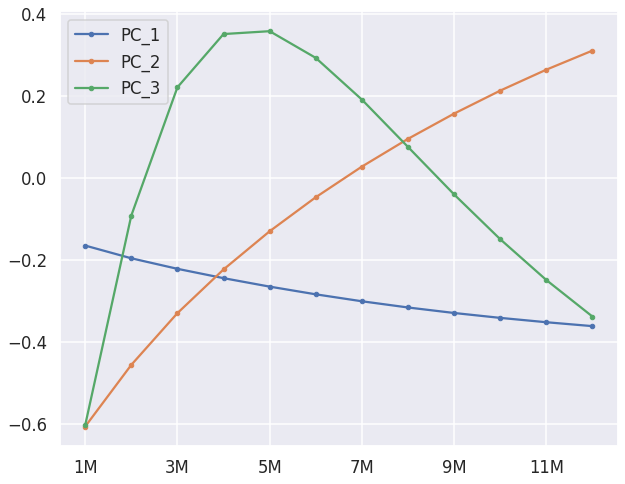

In [16]:
# short terms
short_term_diffs = diffs.iloc[:, :12] 
pca = PCA(3)
pca.fit(short_term_diffs)

components = pd.DataFrame(pca.components_, 
                          columns = short_term_diffs.columns,
                          index=[f'PC_{i + 1}' for i in range(pca.n_components)]).T
components.plot(marker='.')
pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
             columns = ['Cumulative explained variance'],
             index = [f'PC_{i+1}' for i in range(pca.n_components)])

,Cumulative explained variance
PC_1,0.960544
PC_2,0.996807
PC_3,0.999634


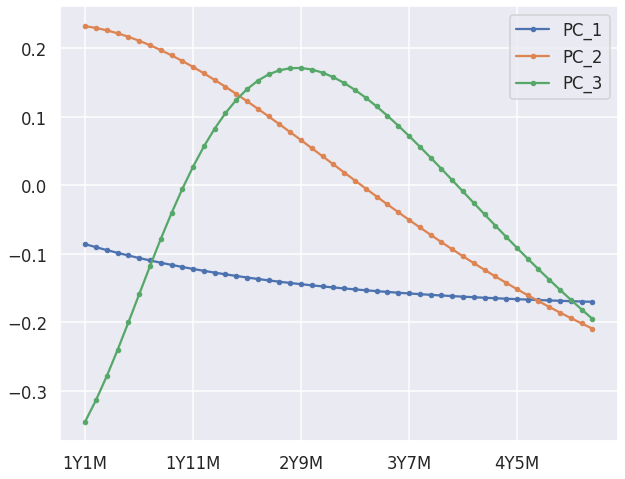

In [15]:
# long terms
longer_term_diffs = diffs.iloc[:, 12:] 
pca = PCA(3)
pca.fit(longer_term_diffs)

components = pd.DataFrame(pca.components_, 
                          columns = longer_term_diffs.columns,
                          index=[f'PC_{i + 1}' for i in range(pca.n_components)]).T
components.plot(marker='.')
pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
             columns = ['Cumulative explained variance'],
             index = [f'PC_{i+1}' for i in range(pca.n_components)])

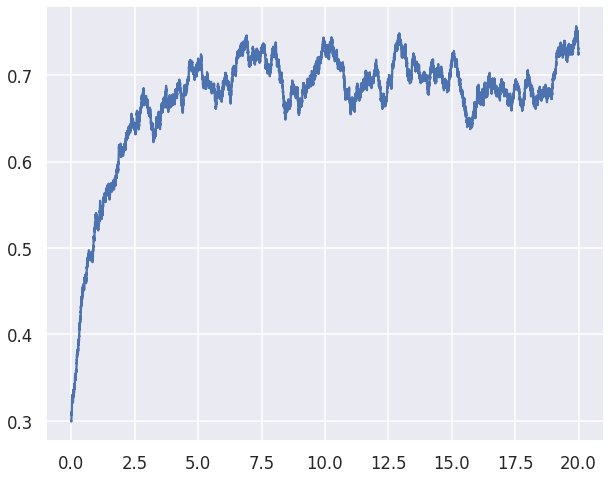

In [22]:
def euler_maruyama(x0: float, a_t: Callable, b_t: Callable, n_steps: int, dt: float, random_toss: Optional[np.array] = None):
        """
        Simulate a stochastic process according to Euler-Maruyama method.
        Parameters
        ----------
        x0: float
            Starting value for the process
        a_t: Callable f: (t, x) -> R
            First characteristic of a stochastic process,
        b_t: Callable f: (t, x) -> R
            Second characteristic of a stochastic process
        n_steps: int
            Number of time discretization steps
        dt: float
            Lenght of a time step
        random_toss: Optional[np.array]
            Array of +1/-1, which is used for Wiener Process approximation.
            If not provided, it gets generated automatically.
        Returns
        -------
        (np.array, np.array)
            Time array and simulated stochastic process values
        """
        if not random_toss:
            random_toss = np.random.rand(n_steps).round()*2 - 1
        if random_toss.shape != (n_steps, ):
            raise ValueError("Incompatible shapes")

        xt = [x0]
        t = [0.]
        for k in range(1, n_steps):
            t_k = k*dt
            x_k = xt[-1] + a_t(t[-1], xt[-1])*dt + b_t(t[-1], xt[-1])*random_toss[k-1]*np.sqrt(dt)
            xt.append(x_k)
            t.append(t_k)
        return np.array(t), np.array(xt)

def vasicek(a: float, b: float, sigma: float, x0: float,
            n_steps: int, dt: float,
            random_toss: Optional[np.array] = None):
    """
    Generate an interest rate trajectory from merton model, using Euler-Maruyama scheme.
    Model:
        dX(t) = b*[a-X(t)]*dt + sigma*dWt
    Parameters
    ----------
    a: float,
     asymptotic, long term level (mean-reversion)
    b: float,
     speed of mean reversion
    sigma: float,
     diffusion parameter
    x0: float,
     starting value
    n_steps: int,
     number of grid points to simulate on
    dt: float,
     distance between the grid points
    random_toss: Optional[np.array],
     optional array of +1 and -1 to simulate Wiener Process. If not passed, will be generated automatically.
    """

    return euler_maruyama(x0,
                          a_t=lambda t, x: b*(a - x),
                          b_t=lambda t, x: sigma,
                          n_steps=n_steps,
                          dt=dt,
                          random_toss=random_toss)


t, xt = vasicek(a = 0.7,
                b = 1.0,
                sigma = 0.04,
                x0 = 0.3,
                n_steps=20000,
                dt=0.001)
plt.plot(t, xt)